<a href="https://colab.research.google.com/github/PadmarajBhat/Machine-Learning/blob/master/BrainTumorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Revisiting the old capstone project with TF2.0

Dataset is hyp5: This data has to be placed in google drive so as to be usable in colab.

In [0]:
import os
import zipfile
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls /content/drive/'My Drive'/1512427

brainTumorDataPublic_1533-2298.zip  brainTumorDataPublic_767-1532.zip
brainTumorDataPublic_1-766.zip	    cvind.mat
brainTumorDataPublic_2299-3064.zip  README.txt


In [4]:
!ls /content/drive/'My Drive'/1512427/brainTumorDataPublic_1-766.zip

'/content/drive/My Drive/1512427/brainTumorDataPublic_1-766.zip'


In [0]:
def return_imageInfo_from_mat_file(file_name):
    f = h5py.File(file_name,'r')
    return np.array(f['cjdata']['PID'],dtype=np.int)[0][0] \
            , np.array(f['cjdata']['image'],dtype=np.int)[0] \
            , np.array(f['cjdata']['label'], dtype=np.int)[0][0] \
    



(49, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

TypeError: ignored

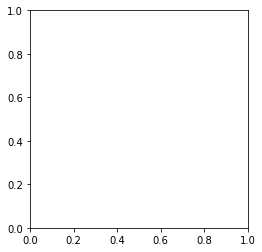

In [34]:
names = ["","meningioma","glioma","pituitary"]
patients_details = []
for root, dirs, files in os.walk("/content/drive/My Drive/1512427/", topdown = False):
   #print(root,dirs,files)
   for f in files:
     if ".zip" in f:
        file = zipfile.ZipFile(root+f, "r")
        for name in file.namelist():
          data = file.read(name)
          #print (name, len(data), repr(data[:10]))
          file.extract(name,".")
          image_info = return_imageInfo_from_mat_file(name)
          
          patients_details.append(image_info)
          #print(return_imageInfo_from_mat_file(name))
          if np.random.randint(1000) < np.random.randint(100):
            print(image_info)
            print( "Image Class : ", names[image_info[2]])
            plt.imshow( image_info[1])
            plt.show()
          
         #break
        break


In [32]:
df = pd.DataFrame(patients_details,columns=["pid","image_data","label"])
df

,pid,image_data,label
0,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
5,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
6,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
8,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
9,49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
